#### Assign 3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)
from sklearn.base import clone

In [2]:
df = pd.read_csv("StudentPerformanceFactorsCleaned.csv")
df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Female,70


We want to predict School_Type. Let's use greedy algorithm to find features to keep.

In [3]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(df[categorical_cols])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_cols))
df_encoded = pd.concat([df, one_hot_df], axis=1)
df_encoded = df_encoded.drop(categorical_cols, axis=1)

In [4]:
df_encoded.columns

Index(['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores',
       'Tutoring_Sessions', 'Physical_Activity', 'Exam_Score',
       'Parental_Involvement_High', 'Parental_Involvement_Low',
       'Parental_Involvement_Medium', 'Access_to_Resources_High',
       'Access_to_Resources_Low', 'Access_to_Resources_Medium',
       'Extracurricular_Activities_No', 'Extracurricular_Activities_Yes',
       'Motivation_Level_High', 'Motivation_Level_Low',
       'Motivation_Level_Medium', 'Internet_Access_No', 'Internet_Access_Yes',
       'Family_Income_High', 'Family_Income_Low', 'Family_Income_Medium',
       'Teacher_Quality_High', 'Teacher_Quality_Low', 'Teacher_Quality_Medium',
       'School_Type_Private', 'School_Type_Public', 'Peer_Influence_Negative',
       'Peer_Influence_Neutral', 'Peer_Influence_Positive',
       'Learning_Disabilities_No', 'Learning_Disabilities_Yes',
       'Parental_Education_Level_College',
       'Parental_Education_Level_High School',
       'Parenta

In [5]:
df_encoded = df_encoded.drop('School_Type_Private', axis=1)

X = df_encoded.drop('School_Type_Public', axis=1)
y = df_encoded['School_Type_Public']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6, stratify=y)

In [7]:
model = LogisticRegression()
rfe = RFE(estimator=model, n_features_to_select=8)
rfe.fit(X_train, y_train)
rfe.transform(X_train)
rfe.transform(X_test)

select_features = X.columns[rfe.get_support()]
print(f"Selected features: {', '.join(select_features)}")

/Users/josephhu/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/josephhu/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

Selected features: Parental_Involvement_Low, Access_to_Resources_Low, Access_to_Resources_Medium, Extracurricular_Activities_No, Extracurricular_Activities_Yes, Internet_Access_Yes, Parental_Education_Level_College, Parental_Education_Level_High School


We will select Parental_Involvement, Access_To_Resources, and Parental_Education_Level as our features. After further testing, I can deduce Extracurricular_Activities and Internet_Access as noise. 

In [8]:
# Mapping:
# School_Type: Public -> 0, Private -> 1

# Parental_Involvement: Low -> 0, Medium -> 1, High -> 2
# Access_To_Resources: Low -> 0, Medium -> 1, High -> 2
# Extracurricular_Activities: No -> 0, Yes -> 1
# Internet_Access: No -> 0, Yes -> 1
# Parental_Education_Level: High School -> 0, College -> 1, Postgraduate -> 2

mapping = {
    'Parental_Involvement': {'Low': 0, 'Medium': 1, 'High': 2},
    'Access_to_Resources': {'Low': 0, 'Medium': 1, 'High': 2},
    'Extracurricular_Activities': {'No': 0, 'Yes': 1},
    'Internet_Access': {'No': 0, 'Yes': 1},
    'Parental_Education_Level': {'High School': 0, 'College': 1, 'Postgraduate': 2},
    'School_Type': {'Public': 0, 'Private': 1},
}

features_to_map = [
    'Parental_Involvement',
    'Access_to_Resources',
    # 'Extracurricular_Activities',
    # 'Internet_Access',
    'Parental_Education_Level',
    'School_Type',
]

existing_mapping = {feature: mapping[feature] for feature in features_to_map if feature in df.columns}
df.replace(existing_mapping, inplace=True)

/var/folders/pm/3_4k3tts4s97kqjkww_vn7k80000gn/T/ipykernel_39071/2798839840.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(existing_mapping, inplace=True)


In [9]:
df = df[features_to_map]
df

,Parental_Involvement,Access_to_Resources,Parental_Education_Level,School_Type
0,0,2,0,0
1,0,1,1,0
2,1,1,2,0
3,0,1,0,0
4,1,1,1,0
...,...,...,...,...
6438,2,1,0,0
6439,2,1,0,0
6440,1,0,2,0
6441,2,2,0,1


In [10]:
X = df.drop('School_Type', axis=1)
y = df['School_Type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [11]:
lr = LogisticRegression(
    penalty='l2',
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced',
    random_state=6
)

lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=6)

In [12]:
conf_matrix = confusion_matrix(y_test, lr.predict(X_test))
print("Confusion Matrix:")
print(conf_matrix)

TN, FP = conf_matrix[0]
FN, TP = conf_matrix[1]

accuracy = (TP + TN) / (TP + TN + FP + FN)
prediction_error = 1 - accuracy
true_positive_rate = TP / (TP + FN)
true_negative_rate = TN / (TN + FP)

print(f"Prediction Accuracy: {accuracy:.4f}")
print(f"Prediction Error: {prediction_error:.4f}")
print(f"True Positive Rate (Recall): {true_positive_rate:.4f}")
print(f"True Negative Rate (Specificity): {true_negative_rate:.4f}")

Confusion Matrix:
[[471 424]
 [205 189]]
Prediction Accuracy: 0.5120
Prediction Error: 0.4880
True Positive Rate (Recall): 0.4797
True Negative Rate (Specificity): 0.5263


Fold: 1
AUC: 0.5202
Accuracy: 0.4686
Fold: 2
AUC: 0.5137
Accuracy: 0.4763
Fold: 3
AUC: 0.5213
Accuracy: 0.5066
Fold: 4
AUC: 0.5285
Accuracy: 0.5225
Fold: 5
AUC: 0.4848
Accuracy: 0.5070


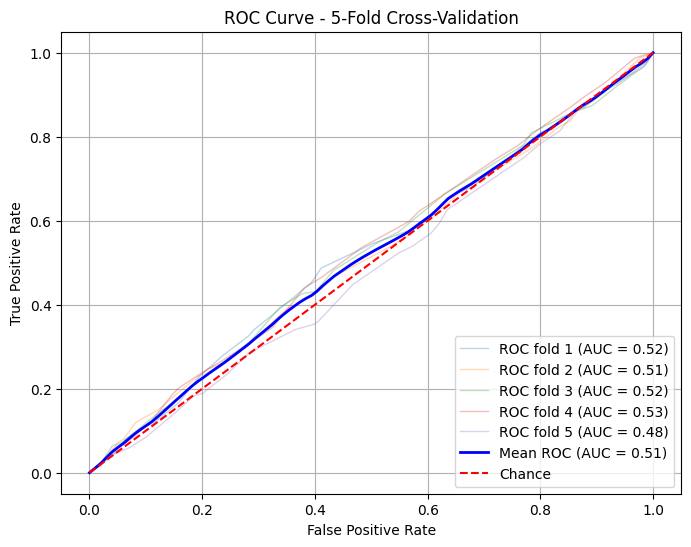


Mean AUC: 0.5137
Mean Accuracy: 0.4962


In [13]:
# Initialize the StratifiedKFold
skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create lists to store AUC and accuracy for each fold
auc_scores = []
accuracy_scores = []
mean_fpr = np.linspace(0, 1, 100)
tprs = []

# Start the plot for ROC curves
plt.figure(figsize=(8, 6))

# Iterate over each fold
i = 1
for train_index, test_index in skfolds.split(X, y):
    # Clone the model to ensure fresh fitting for each fold
    clone_lr = clone(lr)

    # Split the data into training and testing based on the current fold
    X_train_folds = X.iloc[train_index]
    y_train_folds = y.iloc[train_index]
    X_test_fold = X.iloc[test_index]
    
    # Fit the model on the training data
    clone_lr.fit(X_train_folds, y_train_folds)
    
    # Predict probabilities for the positive class
    y_probs = clone_lr.predict_proba(X_test_fold)[:, 1]
    
    # Predict class labels
    y_pred = clone_lr.predict(X_test_fold)

    # Calculate the AUC for this fold
    auc_sample = roc_auc_score(y.iloc[test_index], y_probs)
    auc_scores.append(auc_sample)
    
    # Calculate the accuracy for this fold
    acc_sample = accuracy_score(y.iloc[test_index], y_pred)
    accuracy_scores.append(acc_sample)

    # Calculate the ROC curve
    fpr, tpr, _ = roc_curve(y.iloc[test_index], y_probs)

    # Interpolate the ROC curve for consistent plotting
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

    # Plot the ROC curve for this fold
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i} (AUC = {auc_sample:.2f})')
    
    # Print results for the current fold
    print(f'Fold: {i}')
    print(f'AUC: {auc_sample:.4f}')
    print(f'Accuracy: {acc_sample:.4f}')
    
    i += 1

# Mean ROC curve calculation
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(auc_scores)

# Plot the mean ROC curve
plt.plot(mean_fpr, mean_tpr, color='blue', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)

# Plot the diagonal line (chance)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Chance')

# Customize the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - 5-Fold Cross-Validation')
plt.legend(loc='lower right')
plt.grid(True)

# Show the ROC curve plot
plt.show()

# Print the mean AUC and accuracy
print(f"\nMean AUC: {mean_auc:.4f}")
print(f"Mean Accuracy: {np.mean(accuracy_scores):.4f}")

In [14]:
y_test_proba = lr.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)

f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]

print(f"Best Threshold for F1 Score: {best_threshold:.4f}")
print(f"The F1 score provides a good balance between false positives and false negatives.")

Best Threshold for F1 Score: 0.4415
The F1 score provides a good balance between false positives and false negatives.
